In [1]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np

import boa
%reload_ext boa.ipython

from flash import display_erc20, flash_setup, crvusd_mint

BORROWER = boa.env.eoa
LIQUIDATOR = boa.env.generate_address()
vault, controller, amm, oracle, factory, pool, collateral_token, crvusd = flash_setup()

# Approve tokens for trading
crvusd.approve(amm, 2**256 - 1)
collateral_token.approve(amm, 2**256 - 1)

# Sanity check
print(f"Number of loans in the `{controller._name}` vault: {controller.n_loans()}")


Number of loans in the `VyperWifController` vault: 1


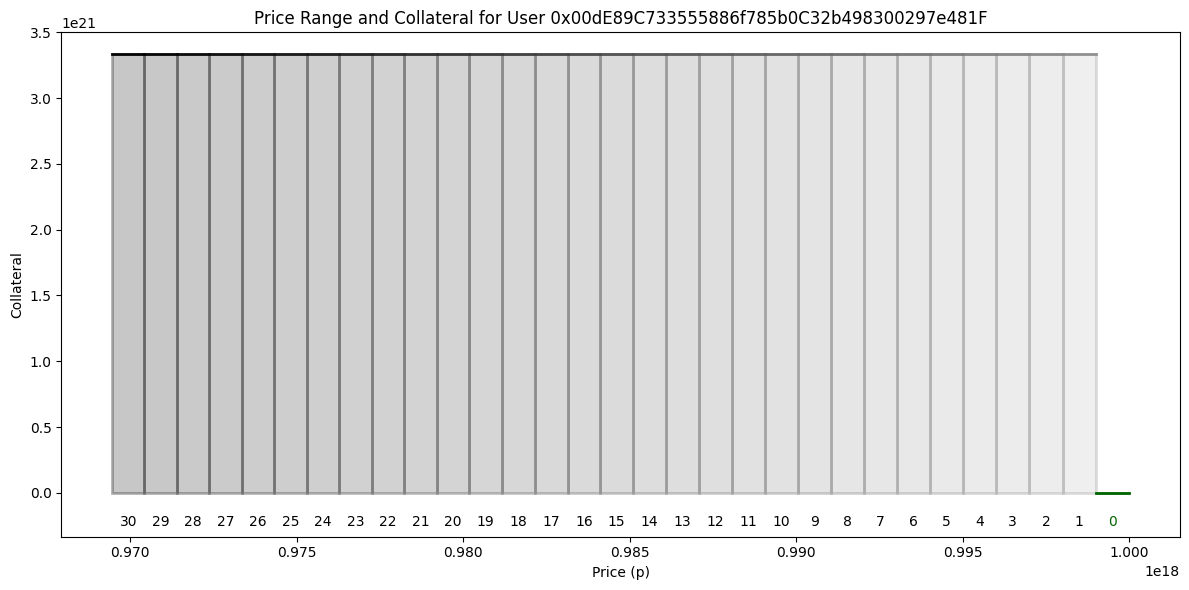

In [2]:
# Helper Functions
SYMBOL = f"${collateral_token.symbol()}"

def user_balances(user, crvusd, collateral):
    print(f"crvUSD: {crvusd.balanceOf(user) / 10 ** 18:,.2f}")
    print(f"Collateral: {collateral.balanceOf(user) / 10 ** 18:,.2f}")

def plot(amm, user):
    bands = range(
        min(0, amm.active_band(), amm.read_user_tick_numbers(user)[0]),
        max(amm.active_band(), amm.read_user_tick_numbers(user)[1]) + 1,
    )

    p_min = [amm.p_oracle_down(n) for n in bands]
    p_max = [amm.p_oracle_up(n) for n in bands]
    y_values = [amm.bands_y(n) for n in bands]

    fig, ax = plt.subplots(figsize=(12, 6))
    grey_cmap = plt.colormaps["Greys"]

    for i, (min_val, max_val, y_val) in enumerate(zip(p_min, p_max, y_values)):
        width = max_val - min_val

        if bands[i] == amm.active_band():
            color = "green"
            edge_color = "darkgreen"
            text_color = "darkgreen"
        else:
            # Use different shades of grey for non-active bands
            color = grey_cmap(0.3 + (i / len(bands)) * 0.5)
            edge_color = grey_cmap(0.5 + (i / len(bands)) * 0.5)
            text_color = "black"

        rect = plt.Rectangle(
            (min_val, 0),
            width,
            y_val,
            fill=True,
            facecolor=color,
            alpha=0.3,
            edgecolor=edge_color,
            linewidth=2,
        )
        ax.add_patch(rect)

        # Add horizontal line for y_val = 0 cases
        ax.plot([min_val, max_val], [y_val, y_val], color=edge_color, linewidth=2)

        # Add band number label below each rectangle
        ax.text(
            (min_val + max_val) / 2,
            -max(y_values) * 0.05,
            f"{bands[i]}",
            ha="center",
            va="top",
            color=text_color,
        )

    ax.set_xlabel("Price (p)")
    ax.set_ylabel("Collateral")
    ax.set_title(f"Price Range and Collateral for User {user}")

    # Set y-axis limit to accommodate labels below x-axis
    ax.set_ylim(bottom=-max(y_values) * 0.1)

    plt.tight_layout()
    plt.show()

def plot_user_states(user_states, oracle_price):
    """
    Visualize the user's state comparing different states.
    
    Parameters:
    - states_list: List of [collat, crvusd, debt] states to compare
    - oracle_price: Current collateral token price in USD
    """
    states_list = []
    for user_state in user_states:
        states_list.append([user_state[0] / 10 ** 18, user_state[1] / 10 ** 18, user_state[2] / 10 ** 18])
    
    
    fontsize = 12
    # Convert input to numpy array for easier manipulation
    states_list = np.array(states_list)
    
    # Number of states to plot
    num_states = len(states_list)
    
    # Compute USD values for collateral token
    collat_values = states_list[:, 0] * oracle_price
    crvusd_values = states_list[:, 1]
    debt_values = states_list[:, 2]
    
    # Prepare state labels (default to generic if not provided)
    if num_states == 2:
        state_labels = ['Initial State', 'Final State']
    elif num_states == 1:
        state_labels = ['Initial State']
    else:
        state_labels = [f'State {i+1}' for i in range(num_states)]
    
    # Create the visualization
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Set the width of each bar and the positions
    bar_width = 0.25
    r1 = np.arange(len(state_labels))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]
    
    # Create stacked bar for collateral (in USD) + crvUSD
    collateral_bars_collat = ax.bar(r1, collat_values, color='orange', width=bar_width, label=f'{SYMBOL} Collateral (USD)')
    collateral_bars_crvusd = ax.bar(r1, crvusd_values, color='green', width=bar_width, 
                                    bottom=collat_values, label='crvUSD Collateral')
    
    # Create separate bar for debt
    debt_bars = ax.bar(r2, debt_values, color='red', width=bar_width, label='Debt')
    
    # Annotate Collateral bars
    for i, bar in enumerate(collateral_bars_collat):
        collat_amount = states_list[i, 0]
        height = bar.get_height()
        ax.annotate(f'{collat_amount:,.4f} {SYMBOL}\n@ ${oracle_price:,.2f}/{SYMBOL}\n= ${height:,.2f}', 
                    xy=(bar.get_x() + bar.get_width() / 2, height/2),
                    xytext=(0, 0), textcoords="offset points", 
                    ha='center', va='center', fontsize=fontsize)
    
    # Annotate crvUSD collateral bars
    for i, bar in enumerate(collateral_bars_crvusd):
        height = bar.get_height()
        bottom = collateral_bars_collat[i].get_height()
        ax.annotate(f'${states_list[i, 1]:,.2f} crvUSD', 
                    xy=(bar.get_x() + bar.get_width() / 2, bottom + height/2),
                    xytext=(0, 0), textcoords="offset points", 
                    ha='center', va='center', fontsize=fontsize)
    
    # Annotate debt bars
    for i, bar in enumerate(debt_bars):
        height = bar.get_height()
        ax.annotate(f'${height:,.2f} Debt', 
                    xy=(bar.get_x() + bar.get_width() / 2, height/2),
                    xytext=(0, 0), textcoords="offset points", 
                    ha='center', va='center', fontsize=fontsize)
    
    # Customize the plot
    ax.set_ylabel("USD Value")
    ax.set_title("User State")

    # Format y-axis with dollar signs and commas
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

    # Set x-ticks and labels
    plt.xticks([r + bar_width/2 for r in range(len(state_labels))], state_labels)
    
    # Add legend
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    
    # Adjust layout
    plt.tight_layout()
    
    # Show the plot
    plt.show()


plot(amm, BORROWER)



# TRADER nukes the pool

In [3]:
# Nuke the pool

# Fund TRADER and set approvals
TRADER = boa.env.generate_address()

crvusd_mint(crvusd, TRADER, 100_000 * 10 ** 18)
with boa.env.prank(collateral_token.owner()):
    collateral_token.transfer(TRADER, 1_000_000 * 10 ** 18)

with boa.env.prank(TRADER):
    crvusd.approve(amm, 2**256 - 1)
    collateral_token.approve(amm, 2**256 - 1)

# Initialize and target price in middle of range
[p_up, p_down] = controller.user_prices(BORROWER)
p_mid = (p_up + p_down) // 2

p_o = oracle.price() 
trade_data = []

# The dumping continues until BORROWER is underwater
while controller.health(BORROWER) > 0:
    
    # ADMIN sets oracle price
    if p_o == p_mid:
        p_o = p_o * 20 // 19
    elif p_o * 19 // 20 < p_mid:
        p_o = p_mid
    else:
        p_o = p_o * 19 // 20
    
    oracle.set_price(p_o, sender=collateral_token.owner())

    # Fast forward
    boa.env.time_travel(seconds=600)

    # TRADER arbs the Llama Lend vault
    trade_amount, is_pump = amm.get_amount_for_price(p_o)
    i = 0  # crvUSD in
    j = 1  # collateral out
    if not is_pump:
        mult = (p_o / 10 ** 18) / 10 ** collateral_token.decimals() 
        i, j = j, i  # collateral in and crvUSD out
    else:
        mult = -1 / 10 ** 18
    amm.exchange(i, j, trade_amount, 0, sender=TRADER)
    trade_data.append([mult * trade_amount, p_o / 10 ** 18, controller.health(BORROWER) / 10 ** 16])



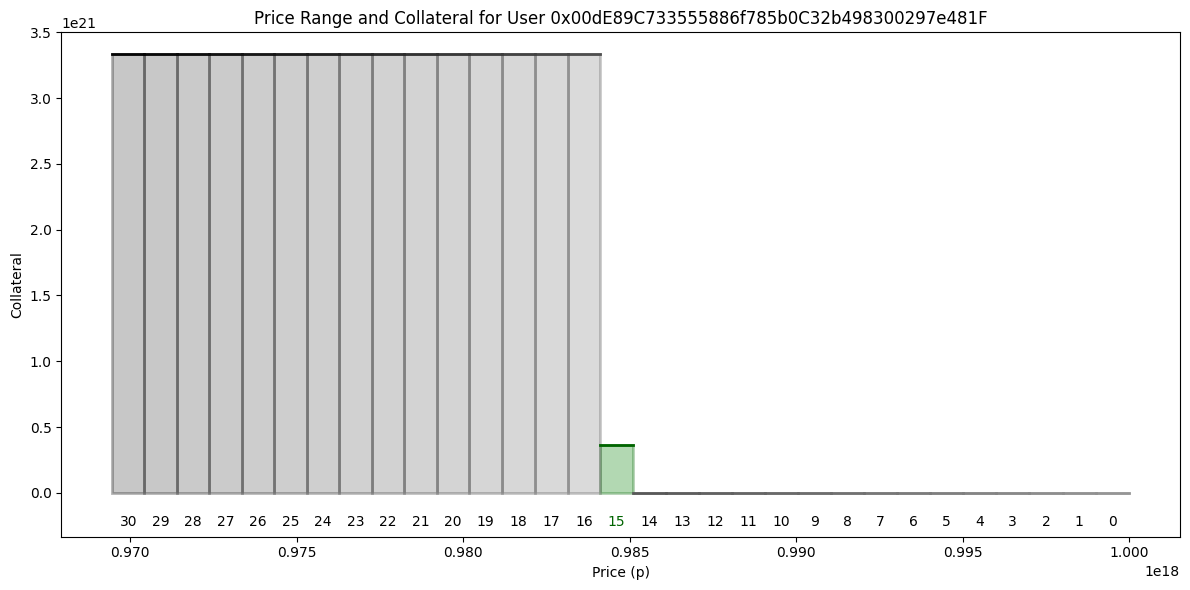

In [4]:
plot(amm, BORROWER)

# BORROWER is subject to liquidation

In [5]:
print(f"Borrower health is down to {controller.health(BORROWER) / 10 ** 18}")

Borrower health is down to -0.006227646746473656


In [6]:
controller.users_to_liquidate()

[(Address('0x00dE89C733555886f785b0C32b498300297e481F'),
  48297569237134477918484,
  50366387486803034757527,
  97126768770609841679805,
  -6227646746473656)]

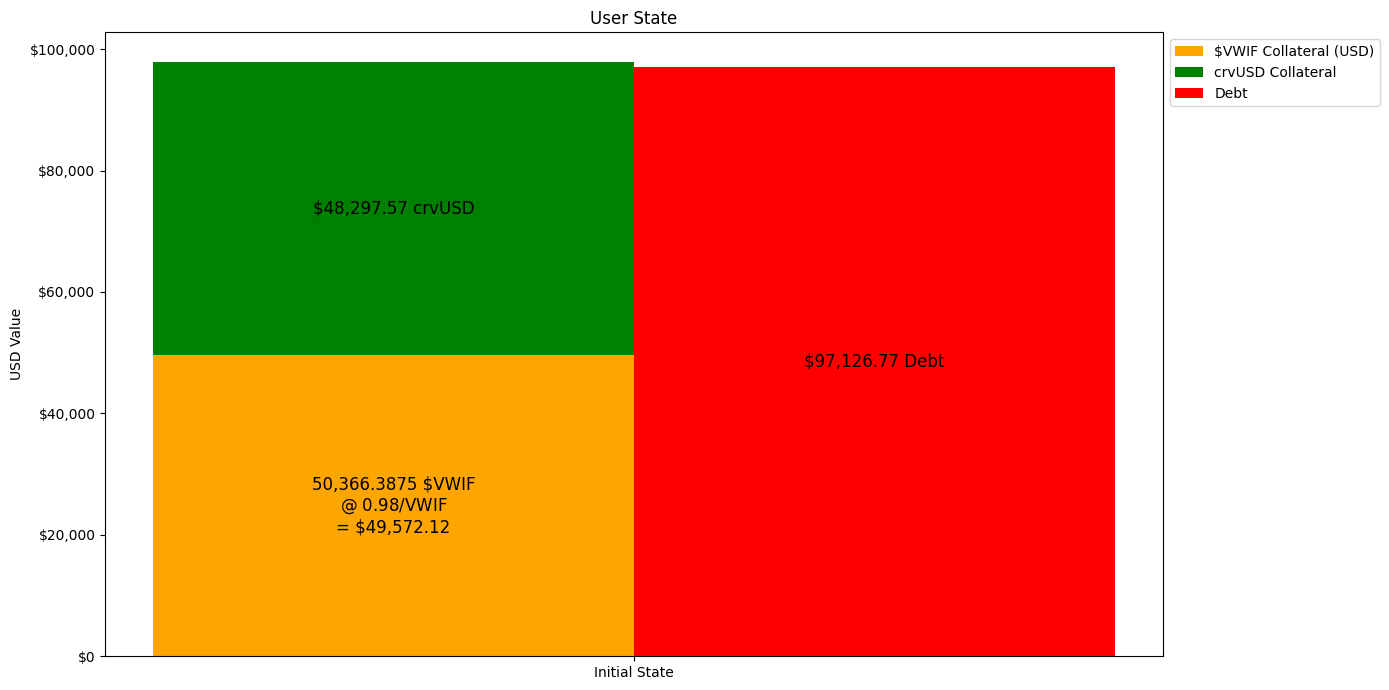

In [7]:
user_state_init = controller.user_state(BORROWER)
plot_user_states([user_state_init], oracle.price_w() / 10 ** 18)


# LIQUIDATOR deploys liquidation contract

In [11]:
%%vyper flash_liquidation_contract
"""
@title Flash Liquidator
@license MIT
@author Curve Finance
@notice You can use this contract to liquidate the deadbeat user
"""
from vyper.interfaces import ERC20


interface FlashLender:
    def flashLoan(
        receiver: address, token: address, amount: uint256, data: Bytes[10**5]
    ) -> bool: nonpayable


interface Controller:
    def liquidate(user: address, min_x: uint256): nonpayable
    def collateral_token() -> ERC20: view
    def borrowed_token() -> ERC20: view


interface Pool:
    def get_dy(i: uint256, j: uint256, dx: uint256) -> uint256: view
    def exchange(
        i: uint256,
        j: uint256,
        dx: uint256,
        min_dy: uint256,
    ) -> uint256: nonpayable


# Contracts
flashlender: public(FlashLender)
controller: public(Controller)
liquidity_pool: public(Pool)

# Tokens
crvusd: public(ERC20)
collateral: public(ERC20)

# EOAs
victim: public(address)
hero: public(address)

@external
def __init__(
    _flashlender_addr: address, _controller_addr: address, _pool_addr: address
):
    # Initialize contracts
    self.flashlender = FlashLender(_flashlender_addr)
    self.controller = Controller(_controller_addr)
    self.liquidity_pool = Pool(_pool_addr)

    # Initialize tokens
    self.collateral = self.controller.collateral_token()
    self.crvusd = self.controller.borrowed_token()


@external
def run_liquidation(victim: address, hero: address):
    """
    @notice Liquidate a crvUSD borrower in bad health
    @dev Trigger the flashlender, which calls back to this contract's `onFlashLoan()`
    @param victim Address of the user subject to liquidation
    """

    # Set addresses
    self.victim = victim
    self.hero = hero

    # Run flashloan
    self.flashlender.flashLoan(
        self,
        self.crvusd.address,
        self.crvusd.balanceOf(self.flashlender.address),
        empty(Bytes[10**5]),
    )


@external
def onFlashLoan(
    sender_addr: address,
    crvusd_addr: address,
    amount: uint256,
    fee: uint256,
    data: Bytes[10**5],
) -> bool:
    """
    @notice The flashlender sends the crvUSD while calling this
    @dev Standardized function, must return the entire loan in the same block or revert
    @param sender_addr This contract's address
    @param crvusd_addr Address of crvUSD stablecoin
    @param amount Value of flashloan (here pulling/returning entire balance)
    @param fee crvUSD flashlender set to 0
    @param data Optional supplemental data
    @return True on success or revert
    """
    assert sender_addr == self

    # Set approvals if needed
    self._approve_self(self.crvusd, self.controller.address)
    self._approve_self(self.collateral, self.liquidity_pool.address)

    # Liquidate the user
    self.controller.liquidate(self.victim, 0)

    # Trade all received collateral into stablecoin
    _balance: uint256 = self.collateral.balanceOf(self) - 500 * 10 ** 18
    _expected: uint256 = self.liquidity_pool.get_dy(1, 0, _balance)
    self.liquidity_pool.exchange(1, 0, _balance, _expected)

    # Repay the flash loan
    self.crvusd.transfer(msg.sender, amount)

    # Anything left to the liquidator
    self.crvusd.transfer(self.hero, self.crvusd.balanceOf(self))
    self.collateral.transfer(self.hero, self.collateral.balanceOf(self))
    return True


@internal
def _approve_self(_token: ERC20, _spender: address):
    """
    @notice Helper function to set max ERC20 approval if missing
    @param _token Token to approve
    @param _spender Authorized spender
    """
    if _token.allowance(self, _spender) == 0:
        _token.approve(_spender, max_value(uint256), default_return_value=True)


In [12]:
flashlender_addr = '0xa7a4bb50af91f90b6feb3388e7f8286af45b299b'
flash_liquidator = flash_liquidation_contract.deploy(flashlender_addr, controller, pool)


In [13]:
with boa.env.anchor():
    with boa.env.prank(LIQUIDATOR):
        flash_liquidator.run_liquidation(BORROWER, LIQUIDATOR)
        print(f"Balance of VyperWif: {collateral_token.balanceOf(LIQUIDATOR) / 10 ** 18}")
        print(f"Balance of crvUSD: {crvusd.balanceOf(LIQUIDATOR) / 10 ** 18}")


Balance of VyperWif: 500.0
Balance of crvUSD: 882.6508672745223
